In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Pip install

In [ ]:
!pip install pydicom -q
!pip install opencv-python -q
!pip install pillow # optional -q
!pip3 install dicom2nifti -q
!pip3 install nibabel -q
!pip3 install pydicom -q
!pip3 install tqdm -q
!pip3 install nilearn -q
!pip install --quiet torchio==0.18.90 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 86.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 75.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.7/172.7 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 9.9 MB/s eta 0:00:00


### Imports

In [ ]:
import pathlib as plb
import tempfile
import os
import dicom2nifti
import nibabel as nib
import numpy as np
import pydicom
import sys
import shutil
import nilearn.image
import pandas as pd
from tqdm import tqdm
from PIL import Image

import enum
import time
import random
import multiprocessing
from pathlib import Path

import torch
import torchvision
import torchio as tio
import torch.nn.functional as F
import torchvision.transforms as T

import numpy as np
# from unet import UNet
from scipy import stats
import matplotlib.pyplot as plt

from IPython import display
from tqdm.auto import tqdm
from pathlib import Path
import pandas as pd
import os
from torchvision.utils import save_image
from skimage.measure import regionprops_table

### Convert dicom to nifti - Not In use

In [ ]:
# data preparation (conversion of DICOM PET/CT studies to nifti format for running automated lesion segmentation)

# run script from command line as follows:
# python tcia_dicom_to_nifti.py /PATH/TO/DICOM/FDG-PET-CT-Lesions/ /PATH/TO/NIFTI/FDG-PET-CT-Lesions/

# you can ignore the nilearn warning:
# .../nilearn/image/resampling.py:527: UserWarning: Casting data from int16 to float32 warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
# or run as python -W ignore tcia_dicom_to_nifti.py /PATH/TO/DICOM/FDG-PET-CT-Lesions/ /PATH/TO/NIFTI/FDG-PET-CT-Lesions/



def find_studies(path_to_data):
    # find all studies
    dicom_root = plb.Path(path_to_data)
    patient_dirs = list(dicom_root.glob('*'))

    study_dirs = []

    for dir in patient_dirs:
        # print(dir)
        sub_dirs = list(dir.glob('*'))
        # print(sub_dirs)
        study_dirs.extend(sub_dirs)

        #dicom_dirs = dicom_dirs.append(dir.glob('*'))
    return study_dirs


def identify_modalities(study_dir):
    # identify CT, PET and mask subfolders and return dicitionary of modalities and corresponding paths, also return series ID, output is a dictionary
    study_dir = plb.Path(study_dir)
    sub_dirs = list(study_dir.glob('*'))
    # print(sub_dirs)

    modalities = {}

    for dir in sub_dirs:
        # print(dir)
        # print(dir.glob('*.dcm'))
        first_file = next(dir.glob('*.dcm'))
        # print(first_file)
        ds = pydicom.dcmread(str(first_file))
        #print(ds)
        modality = ds.Modality
        modalities[modality] = dir

    modalities["ID"] = ds.StudyInstanceUID
    return modalities


def dcm2nii_CT(CT_dcm_path, nii_out_path):
    # conversion of CT DICOM (in the CT_dcm_path) to nifti and save in nii_out_path
    with tempfile.TemporaryDirectory() as tmp: #convert CT
        tmp = plb.Path(str(tmp))
        # convert dicom directory to nifti
        # (store results in temp directory)
        dicom2nifti.convert_directory(CT_dcm_path, str(tmp),
                                      compression=True, reorient=True)
        nii = next(tmp.glob('*nii.gz'))
        # copy niftis to output folder with consistent naming
        shutil.copy(nii, nii_out_path/'CT.nii.gz')


def dcm2nii_PET(PET_dcm_path, nii_out_path):
    # conversion of PET DICOM (in the PET_dcm_path) to nifti (and SUV nifti) and save in nii_out_path
    first_pt_dcm = next(PET_dcm_path.glob('*.dcm'))
    suv_corr_factor = calculate_suv_factor(first_pt_dcm)

    with tempfile.TemporaryDirectory() as tmp: #convert PET
        tmp = plb.Path(str(tmp))
        # convert dicom directory to nifti
        # (store results in temp directory)
        dicom2nifti.convert_directory(PET_dcm_path, str(tmp),
                                    compression=True, reorient=True)
        nii = next(tmp.glob('*nii.gz'))
        # copy nifti to output folder with consistent naming
        shutil.copy(nii, nii_out_path/'PET.nii.gz')

        # convert pet images to quantitative suv images and save nifti file
        suv_pet_nii = convert_pet(nib.load(nii_out_path/'PET.nii.gz'), suv_factor=suv_corr_factor)
        nib.save(suv_pet_nii, nii_out_path/'SUV.nii.gz')


def conv_time(time_str):
    # function for time conversion in DICOM tag
    return (float(time_str[:2]) * 3600 + float(time_str[2:4]) * 60 + float(time_str[4:13]))


def calculate_suv_factor(dcm_path):
    # reads a PET dicom file and calculates the SUV conversion factor
    ds = pydicom.dcmread(str(dcm_path))
    total_dose = ds.RadiopharmaceuticalInformationSequence[0].RadionuclideTotalDose
    start_time = ds.RadiopharmaceuticalInformationSequence[0].RadiopharmaceuticalStartTime
    half_life = ds.RadiopharmaceuticalInformationSequence[0].RadionuclideHalfLife
    acq_time = ds.AcquisitionTime
    weight = ds.PatientWeight
    time_diff = conv_time(acq_time) - conv_time(start_time)
    act_dose = total_dose * 0.5 ** (time_diff / half_life)
    suv_factor = 1000 * weight / act_dose
    return suv_factor


def convert_pet(pet, suv_factor):
    # function for conversion of PET values to SUV (should work on Siemens PET/CT)
    affine = pet.affine
    pet_data = pet.get_fdata()
    pet_suv_data = (pet_data*suv_factor).astype(np.float32)
    pet_suv = nib.Nifti1Image(pet_suv_data, affine)
    return pet_suv


def dcm2nii_mask(mask_dcm_path, nii_out_path):
    # conversion of the mask dicom file to nifti (not directly possible with dicom2nifti)
    mask_dcm = list(mask_dcm_path.glob('*.dcm'))[0]
    mask = pydicom.read_file(str(mask_dcm))
    mask_array = mask.pixel_array

    # get mask array to correct orientation (this procedure is dataset specific)
    mask_array = np.transpose(mask_array,(2,1,0) )
    mask_orientation = mask[0x5200, 0x9229][0].PlaneOrientationSequence[0].ImageOrientationPatient
    if mask_orientation[4] == 1:
        mask_array = np.flip(mask_array, 1 )

    # get affine matrix from the corresponding pet
    pet = nib.load(str(nii_out_path/'PET.nii.gz'))
    pet_affine = pet.affine

    # return mask as nifti object
    mask_out = nib.Nifti1Image(mask_array, pet_affine)
    nib.save(mask_out, nii_out_path/'SEG.nii.gz')


def resample_ct(nii_out_path):
    # resample CT to PET and mask resolution
    ct   = nib.load(nii_out_path/'CT.nii.gz')
    pet  = nib.load(nii_out_path/'PET.nii.gz')
    CTres = nilearn.image.resample_to_img(ct, pet, fill_value=-1024)
    nib.save(CTres, nii_out_path/'CTres.nii.gz')


def tcia_to_nifti(tcia_path, nii_out_path, modality='CT'):
    # conversion for a single file
    # creates a nifti file for one patient/study
    # tcia_path:        path to a DICOM directory for a specific study of one patient
    # nii_out_path:     path to a directory where nifti file for one patient, study and modality will be stored
    # modality:         modality to be converted CT, PET or mask ('CT', 'PT', 'SEG')
    os.makedirs(nii_out_path, exist_ok=True)
    if modality == 'CT':
        dcm2nii_CT(tcia_path, nii_out_path)
        resample_ct(nii_out_path)
    elif modality == 'PET':
        dcm2nii_PET(tcia_path, nii_out_path)
    elif modality == 'SEG':
        dcm2nii_mask(tcia_path, nii_out_path)


def tcia_to_nifti_study(study_path, nii_out_path):
    # conversion for a single study
    # creates NIfTI files for one patient
    # study_path:       path to a study directory containing all DICOM files for a specific study of one patient
    # nii_out_path:     path to a directory where all nifti files for one patient and study will be stored
    study_path = plb.Path(study_path)
    modalities = identify_modalities(study_path)
    nii_out_path = plb.Path(nii_out_root / study_path.parent.name)
    nii_out_path = nii_out_path/study_path.name
    os.makedirs(nii_out_path, exist_ok=True)

    ct_dir = modalities["CT"]
    dcm2nii_CT(ct_dir, nii_out_path)

    pet_dir = modalities["PT"]
    dcm2nii_PET(pet_dir, nii_out_path)

    seg_dir = modalities["SEG"]
    dcm2nii_mask(seg_dir, nii_out_path)

    resample_ct(nii_out_path)


def convert_tcia_to_nifti(study_dirs,nii_out_root):
    # batch conversion of all patients
    for study_dir in tqdm(study_dirs):

        patient = study_dir.parent.name
        print("The following patient directory is being processed: ", patient)

        modalities = identify_modalities(study_dir)
        nii_out_path = plb.Path(nii_out_root/study_dir.parent.name)
        nii_out_path = nii_out_path/study_dir.name
        os.makedirs(nii_out_path, exist_ok=True)

        ct_dir = modalities["CT"]
        dcm2nii_CT(ct_dir, nii_out_path)

        pet_dir = modalities["PT"]
        dcm2nii_PET(pet_dir, nii_out_path)

        seg_dir = modalities["SEG"]
        dcm2nii_mask(seg_dir, nii_out_path)

        resample_ct(nii_out_path)


def start_conversion(path_to_data,nii_out_root):
    path_to_data = path_to_data  # path to downloaded TCIA DICOM database, e.g. '.../FDG-PET-CT-Lesions/'
    nii_out_root = nii_out_root  # path to the to be created NiFTI files, e.g. '...tcia_nifti/FDG-PET-CT-Lesions/')

    study_dirs = find_studies(path_to_data)
    print(study_dirs)
    convert_tcia_to_nifti(study_dirs, nii_out_root)

In [ ]:
path_to_data = plb.Path('/content/drive/MyDrive/PET-CT Capstone Project/FDG-PET-CT-Lesions/test')
nii_out_root = plb.Path('/content/sample_data/NIFTI/')

In [ ]:
start_conversion(path_to_data=path_to_data, nii_out_root=nii_out_root)

[PosixPath('/content/drive/MyDrive/PET-CT Capstone Project/FDG-PET-CT-Lesions/test/PETCT_0e2034240b/01-31-2003-NA-PET-CT Ganzkoerper  primaer mit KM-08517')]


  0%|          | 0/1 [00:00<?, ?it/s]

The following patient directory is being processed:  PETCT_0e2034240b
[PosixPath('/content/drive/MyDrive/PET-CT Capstone Project/FDG-PET-CT-Lesions/test/PETCT_0e2034240b/01-31-2003-NA-PET-CT Ganzkoerper  primaer mit KM-08517/6.000000-PET corr.-65241'), PosixPath('/content/drive/MyDrive/PET-CT Capstone Project/FDG-PET-CT-Lesions/test/PETCT_0e2034240b/01-31-2003-NA-PET-CT Ganzkoerper  primaer mit KM-08517/300.000000-Segmentation-11579'), PosixPath('/content/drive/MyDrive/PET-CT Capstone Project/FDG-PET-CT-Lesions/test/PETCT_0e2034240b/01-31-2003-NA-PET-CT Ganzkoerper  primaer mit KM-08517/4.000000-GK p.v.3-05870')]


/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:591: UserWarning: Casting data from int16 to float32
  warnings.warn(f"Casting data from {data.dtype.name} to {aux}")
100%|██████████| 1/1 [01:30<00:00, 90.24s/it]


# Reading Nifti Using TorchIO

## Preprocess

In [ ]:
## Constants
all_patients_csv = '/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/Shared_csv/all_patients.csv'

df = pd.read_csv(all_patients_csv)

print(df['diagnosis'].value_counts())

NEGATIVE       1539
MELANOMA        564
LUNG_CANCER     504
LYMPHOMA        435
Name: diagnosis, dtype: int64


In [ ]:
test = df[df['diagnosis'] == 'LYMPHOMA']
unique_lymphoma = list(set(list(test['Subject ID'])))
unique_lymphoma[:10]

['PETCT_1956667fce',
 'PETCT_f2f28337ba',
 'PETCT_07574bfa00',
 'PETCT_1f6b6b0548',
 'PETCT_0beb67c923',
 'PETCT_73fda3a382',
 'PETCT_ea6c621616',
 'PETCT_e4749cda88',
 'PETCT_2e97a9e5c2',
 'PETCT_22d07bdc49']

In [ ]:
test = df[df['diagnosis'] == 'LUNG_CANCER']
unique_lung_cancer = list(set(list(test['Subject ID'])))
unique_lung_cancer[:10]

['PETCT_e03b96666f',
 'PETCT_d3d61785e6',
 'PETCT_55ae7986e1',
 'PETCT_3b26172779',
 'PETCT_e9e1a391b5',
 'PETCT_d4b2ff9721',
 'PETCT_465176d213',
 'PETCT_77bceab232',
 'PETCT_bf178a41b2',
 'PETCT_e77c5fca12']

# Data Preprocessing and Slicing




In [ ]:
debug = False

In [ ]:
# Processor Class
class TwoDimensionSlicesProcessing():
  def __init__(self,
               nifti_folder: str,
               output_folder: str,
               label: str,
               label_file: str,
               channels: int,
               save_negatives: bool,
               voxel_size: int = 2,
               plane: str = 'axial'
  ):

    self.nifti_folder = plb.Path(nifti_folder)
    self.output_folder = plb.Path(output_folder)

    # make folder
    if not os.path.isdir(self.output_folder):
      os.mkdir(self.output_folder)

    self.label = label
    self.label_file = plb.Path(label_file)

    self.voxel_size = voxel_size
    self.transform = tio.transforms.Resample(self.voxel_size)

    self.channels = channels
    assert self.channels in [1, 3]

    self.save_negatives = save_negatives

    self.plane = plane
    self.plane_to_axis = {
        'axial': 2,     # x-axis
        'coronal': 1,   # y-axis
        'sagittal': 0   # z-axis
    }
    self.axis = self.plane_to_axis.get(self.plane, None)

    assert self.axis is not None

    self.delim = ','


  def find_suv_files(self):
    # find all suv files
    patient_dirs = list(self.nifti_folder.glob('*'))

    suv_dirs = []
    suv_and_seg_files = 'S[UE][VG].nii.gz'

    for dir in patient_dirs:
      # print(dir)
      sub_dirs = list(dir.rglob(suv_and_seg_files))
      # print(sub_dirs)
      suv_dirs.append(sub_dirs) # list of lists[2] with matching SUV and SEG files

    return suv_dirs


  def load_and_standardize_spacing(self, suv_file, seg_file):
    # load files
    suv_img = tio.ScalarImage(suv_file)
    seg_label = tio.LabelMap(seg_file)
    # print(torch.max(suv_img.data), torch.max(seg_label.data))

    # standardize spacing
    return self.transform(suv_img).data, self.transform(seg_label).data


  def get_2d_bb_indices(self, seg_label):
    # find max indices of segment mask
    # ax2_min, ax1_min = torch.min(torch.nonzero(seg_label.data), axis=0).values
    # ax2_max, ax1_max = torch.max(torch.nonzero(seg_label.data), axis=0).values

    # check if no positive labels in slice
    if torch.nonzero(seg_label).numel() == 0:
      return None

    # get connected components and bb labels
    props = regionprops_table(seg_label.numpy(), properties=('label', 'bbox'))
    bb_df = pd.DataFrame(props)

    bb_indices = []

    for index, row in bb_df.iterrows():
      # bbox-0 to bbox-3: (min_row, min_col, max_row, max_col)
      # Pixels belonging to the bounding box are in the half-open interval
      # [min_row; max_row) and [min_col; max_col).
      # ax1: column, ax2: row
      # want to return as ax1_min, ax2_min, ax1_max, ax2_max
      bb_indices.append([row['bbox-1'], row['bbox-0'], row['bbox-3'], row['bbox-2']])

    return bb_indices


  def get_3d_bb_indices(self, seg_label):
    # find max indices of segment mask
    _, z_min, y_min, x_min = torch.min(torch.nonzero(seg_label.data), axis=0).values
    _, z_max, y_max, x_max = torch.max(torch.nonzero(seg_label.data), axis=0).values

    return [z_min, z_max, y_min, y_max, x_min, x_max]


  def extend_bb_label(self, seg_label):
    # find max indices of segment mask
    z_min, z_max, y_min, y_max, x_min, x_max = self.get_bb_indices(seg_label)

    # set voxels in 3D bb to 1
    bb_label = seg_label.tensor.clone()
    bb_label[0, z_min:z_max+1, y_min:y_max+1, x_min:x_max+1] = 1

    return bb_label


  # def get_scaled_slice(self, suv_tensor_slice):
  #   # scale image to 255 using max-min
  #   scaled_slice = (suv_tensor_slice - torch.min(suv_tensor_slice)) / \
  #                  (torch.max(suv_tensor_slice) - torch.min(suv_tensor_slice) + 1e-6) * 255
  #   scaled_slice = scaled_slice.clamp(0, 255)

  #   # scaled_slice = suv_tensor_slice

  #   return scaled_slice


  def process_three_channels(self, suv_img_permuted, a_i):
    axis_max = suv_img_permuted.shape[0]

    # skip if lower/upper slice out of bound
    if a_i == 0 or a_i == axis_max - 1:
      return None

    return suv_img_permuted[a_i-1:a_i+2, :, :]


  def run(self):
    # get list of subjects
    suv_nii_files = self.find_suv_files()

    # load SUV image
    for seg_file, suv_file in tqdm(suv_nii_files):
      # swap file names if needed
      if 'SUV' in str(seg_file):
        seg_file, suv_file = suv_file, seg_file

      # get patient ID
      patient_id = seg_file.parts[-3]

      # load nii files
      suv_img, seg_label = self.load_and_standardize_spacing(suv_file, seg_file)
      # bb_indices = self.get_3d_bb_indices(seg_label)   # z_min, z_max, y_min, y_max, x_min, x_max

      # convert each slice to PIL Image and save
      suv_img = suv_img.squeeze() # convert to C x H x W from B x C x H x W
      seg_label = seg_label.squeeze()
      # print(suv_img.shape)

      # permute image by axis
      if self.axis == 0:
        # sagittal plane
        permute_axis = (0, 1, 2)
      elif self.axis == 1:
        # coronal plane
        permute_axis = (1, 0, 2)
      elif self.axis == 2:
        # axial plane
        permute_axis = (2, 0, 1)

      suv_img_permuted = torch.permute(suv_img, permute_axis)
      seg_label_permuted = torch.permute(seg_label, permute_axis)

      # Faster-RCNN does not support images without detections
      # for a_i in range(bb_indices[self.axis*2], bb_indices[self.axis*2+1]):
      ax_max_idx = suv_img_permuted.shape[0]
      for a_i in range(0, ax_max_idx):
        suv_tensor_slice = suv_img_permuted[a_i, :, :]
        seg_label_slice = seg_label_permuted[a_i, :, :]

        # get bb indices
        slice_bb_indices = self.get_2d_bb_indices(seg_label_slice)

        if not self.save_negatives and not slice_bb_indices:
          # skip if not saving negatives or no lesion in image
          # print(slice_bb_indices)
          continue

        if self.channels == 3:
          suv_tensor_slice = self.process_three_channels(suv_img_permuted, a_i)
          # print(suv_tensor_slice.shape)

        if suv_tensor_slice is None:
          continue

        # save image
        img_file_name = f'{patient_id}_{self.plane}_{a_i:0>3}.jpg'
        img_path = self.output_folder / img_file_name

        kwargs = {'normalize': True}
        save_image(suv_tensor_slice, img_path, **kwargs)

        if slice_bb_indices:
          # create csv label
          with open(self.label_file, 'a') as op:
            for ax1_min, ax2_min, ax1_max, ax2_max in slice_bb_indices:
              op.write(
                  (f'{img_file_name}{self.delim}'
                  f'{ax1_min}{self.delim}{ax2_min}{self.delim}'
                  f'{ax1_max}{self.delim}{ax2_max}{self.delim}'
                  f'{self.label}\n')
              )


# Usage of above class

Run on all Lung Cancer patients

In [ ]:
for lc_patient in tqdm(unique_lung_cancer):
  DataProcessor = TwoDimensionSlicesProcessing(nifti_folder=f'/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/{lc_patient}',
                                              output_folder='/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/preprocessed_data/lung_cancer/data',
                                              label='lung',
                                              label_file='/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/preprocessed_data/lung_cancer/labels/labels.csv',
                                              channels=3,
                                              save_negatives=False)

  DataProcessor.run()

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Visualize

In [ ]:
# search sample
df = pd.read_csv('/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/preprocessed_data/lung_cancer/labels/labels.csv', header=None)
df.head()

,0,1,2,3,4,5
0,PETCT_55ae7986e1_axial_357.jpg,205,165,207,169,lung
1,PETCT_55ae7986e1_axial_358.jpg,203,163,208,170,lung
2,PETCT_55ae7986e1_axial_359.jpg,203,163,208,170,lung
3,PETCT_55ae7986e1_axial_360.jpg,203,164,208,170,lung
4,PETCT_3b26172779_axial_123.jpg,153,210,163,217,lung


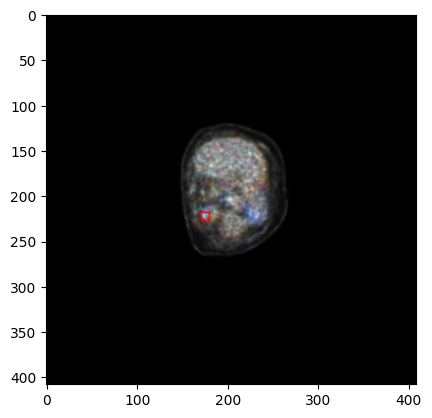

In [ ]:
import matplotlib.patches as patches

img_name = "/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/preprocessed_data/lung_cancer/data/PETCT_0e2034240b_axial_216.jpg"
im = Image.open(img_name)

xmin, ymin, xmax, ymax = df.loc[df[0] == img_name.split('/')[-1], 1:4].values[0]

fig, ax = plt.subplots()

xlen = xmax - xmin
ylen = ymax - ymin

rect = patches.Rectangle((xmin, ymin), xlen, ylen, linewidth=1, edgecolor='r', facecolor='none')

plt.imshow(im)
ax.add_patch(rect)

Run on all Nifti images

In [ ]:
# nifti_file = 'PETCT_13b40a817b'
DataProcessor = TwoDimensionSlicesProcessing(nifti_folder=f'/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti',
                                             output_folder='/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/preprocessed_data/all/data',
                                             label='lung',
                                             label_file='/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/preprocessed_data/lung_cancer/labels/labels.csv',
                                             channels=3,
                                             save_negatives=False)

DataProcessor.run()

### Verify Images and Labels

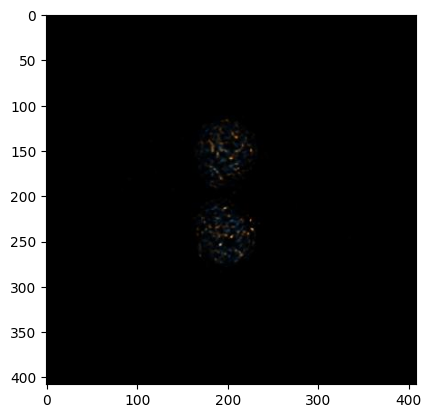

In [ ]:
im = Image.open("/content/sample_data/Sliced Images/PETCT_62b114e09b_axial_001.jpg")
im.size
plt.imshow(im)

# df = pd.read_csv('/content/sample_data/labels.csv')

# Driver code for extracting 2D coordinates from Nifti

In [ ]:
## Path of NIfti Folders
base_path = '/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti'
## Path of specific cancer type
channels = 3

lung_cancer_patients_csv= '/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/Shared_csv/lung_cancer_patients.csv'
negative_patients= '/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/Shared_csv/negative_patients.csv'
melanoma_patients= '/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/Shared_csv/melanoma_patients.csv'
lymphoma_patients= '/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/Shared_csv/lymphoma_patients.csv'


df = pd.read_csv(lymphoma_patients)
subject_ids = list(df['Subject ID'])
print(len(subject_ids))

subject_ids = list(set(subject_ids))
print(len(subject_ids))
print(subject_ids[:10])

435
144
['PETCT_249dd35d0c', 'PETCT_9ffd8409b3', 'PETCT_07574bfa00', 'PETCT_05808cf24e', 'PETCT_1fe6e48293', 'PETCT_223f70f0b0', 'PETCT_2ce074c2ea', 'PETCT_3fd361ec14', 'PETCT_61348439bf', 'PETCT_8de6953d23']


In [ ]:
label = 'lymphoma'
output_folder  = f'/content/drive/MyDrive/preprocessed_data/{label}/data'
label_folder  = f'/content/drive/MyDrive/preprocessed_data/{label}/labels'
label_file= f'/content/drive/MyDrive/preprocessed_data/{label}/labels/labels.csv'

if not os.path.exists(output_folder):
    os.mkdir(output_folder)

if not os.path.exists(label_folder):
    os.mkdir(label_folder)

print("created")

created


In [ ]:
subject_ids_not_processed = []
label = 'lymphoma'
for subject_id in tqdm(subject_ids):
  try:
      ## Nifti folder for each subject id
      nifti_folder = f'{base_path}/{subject_id}'
      ## Data Preprocessor object to extract 2d coordinates
      print(nifti_folder)

      DataProcessor = TwoDimensionSlicesProcessing(nifti_folder=nifti_folder,
                                                  output_folder=output_folder,
                                                   label=label,
                                                  label_file=label_file,
                                                   channels=channels
                                                   )
      DataProcessor.run()

  except Exception as e  :
      print(e)
      print("Unable to process : ", subject_id)
      subject_ids_not_processed.append(subject_id)


  0%|          | 0/144 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_249dd35d0c


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_9ffd8409b3


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_07574bfa00


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_05808cf24e


  0%|          | 0/2 [00:00<?, ?it/s]

min(): Expected reduction dim 0 to have non-zero size.
Unable to process :  PETCT_05808cf24e
/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_1fe6e48293


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_223f70f0b0


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_2ce074c2ea


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_3fd361ec14


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_61348439bf


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_8de6953d23


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_323cc5aff8


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_ddca6cfba6


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_15f4b7254f


  0%|          | 0/2 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_456d14846b


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_62b114e09b


  0%|          | 0/2 [00:00<?, ?it/s]

min(): Expected reduction dim 0 to have non-zero size.
Unable to process :  PETCT_62b114e09b
/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_c4a686881e


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_74bbceaeeb


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_c3cc732d95


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_80d7e682f7


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_ae3074834a


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_e0aa99fa04


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_2dc17aaeaf


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_13d0984c93


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_59e6d1de22


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_5cf118ac06


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_f1501b1f45


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_b7c1533a39


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_987c8a1160


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_119165872d


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_a19ef8e0d2


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_510fb36781


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_9d6699f215


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_7a8a062ed5


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_16cdbc8689


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_556b56485a


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_e61c9da258


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_ac75e49284


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_08212d7f6c


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_ca47fe5e7d


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_901573a747


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_8b74860ce6


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_97320b0b58


  0%|          | 0/2 [00:00<?, ?it/s]

min(): Expected reduction dim 0 to have non-zero size.
Unable to process :  PETCT_97320b0b58
/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_62405d117c


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_ae96f738c0


  0%|          | 0/2 [00:00<?, ?it/s]

min(): Expected reduction dim 0 to have non-zero size.
Unable to process :  PETCT_ae96f738c0
/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_63508c679d


  0%|          | 0/2 [00:00<?, ?it/s]

min(): Expected reduction dim 0 to have non-zero size.
Unable to process :  PETCT_63508c679d
/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_9a2c6e618a


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_fb014a1ea0


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_49f3d297b0


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_68f73c4518


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_ea6c621616


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_ddbb3c69f0


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_108c1763d4


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_0beb67c923


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_1fc35d02da


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_d31c9ebd93


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_73fda3a382


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_d51664a9e4


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_8a52353a72


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_f47e31ceb5


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_cbbc9e2879


  0%|          | 0/4 [00:00<?, ?it/s]

min(): Expected reduction dim 0 to have non-zero size.
Unable to process :  PETCT_cbbc9e2879
/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_e77124b7f4


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_44b08f570e


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_11e258cc1f


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_ea0fd89f0f


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_4848bebb10


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_1f6b6b0548


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_d3dac0d1cd


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_790246c76c


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_6170317f2e


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_0f44cec2e6


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_249c02c01c


  0%|          | 0/2 [00:00<?, ?it/s]

min(): Expected reduction dim 0 to have non-zero size.
Unable to process :  PETCT_249c02c01c
/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_8ec13728df


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_1956667fce


  0%|          | 0/2 [00:00<?, ?it/s]

min(): Expected reduction dim 0 to have non-zero size.
Unable to process :  PETCT_1956667fce
/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_d40a16781a


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_f21755a99b


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_0b57b247b6


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_644d80e987


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_a4ff5d0d9d


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_b53ba7c6bf


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_527c5afc5d


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_dd68a71e0a


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_5ef99b0b6b


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_1b1bdfc35b


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_e69152b6b4


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_fe705ea1cc


  0%|          | 0/2 [00:00<?, ?it/s]

min(): Expected reduction dim 0 to have non-zero size.
Unable to process :  PETCT_fe705ea1cc
/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_7147385005


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_c29aba73da


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_0fa313309d


  0%|          | 0/2 [00:00<?, ?it/s]

min(): Expected reduction dim 0 to have non-zero size.
Unable to process :  PETCT_0fa313309d
/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_f144b214af


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_9f206193d3


  0%|          | 0/2 [00:00<?, ?it/s]

min(): Expected reduction dim 0 to have non-zero size.
Unable to process :  PETCT_9f206193d3
/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_642d6c78d6


  0%|          | 0/2 [00:00<?, ?it/s]

min(): Expected reduction dim 0 to have non-zero size.
Unable to process :  PETCT_642d6c78d6
/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_4011ffe8ae


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_5d10be5b89


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_db3daf78d2


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_e44480b9b8


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_0223010e46


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_2202a936e0


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_ed9dca00d2


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_f2f28337ba


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_ad7cd4a9d2


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_b509ace2a2


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_60baa6979c


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_f9e0c504af


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_08cdb15e0b


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_fbd907a179


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_2f9aec0275


  0%|          | 0/2 [00:00<?, ?it/s]

min(): Expected reduction dim 0 to have non-zero size.
Unable to process :  PETCT_2f9aec0275
/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_ea051a3e6c


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_65bd1a4c38


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_dd8f9f217c


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_62011ff15b


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_30001118d0


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_cd2ef932b5


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_4076ea9a15


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_5ac322455f


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_2e97a9e5c2


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_e4712dc58c


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_870181d7fd


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_ca89066e44


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_b2f82ed4b9


  0%|          | 0/2 [00:00<?, ?it/s]

min(): Expected reduction dim 0 to have non-zero size.
Unable to process :  PETCT_b2f82ed4b9
/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_04ab5c61c9


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_55ca11402a


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_b04be2846e


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_685d7c09b5


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_6a3477cd9a


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_6c469107a0


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_aa27cb9156


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_548213edf7


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_3d6f425a76


  0%|          | 0/2 [00:00<?, ?it/s]

min(): Expected reduction dim 0 to have non-zero size.
Unable to process :  PETCT_3d6f425a76
/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_ea42c88cc7


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_e4749cda88


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_b3d4773f85


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_c898e2abcb


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_2b60c8135a


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_9aa97cf103


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_21e4ffcb52


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_5de3ac617a


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_bb45bfcffd


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_22d07bdc49


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_0f4ee9e078


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_350e91119a


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_a7b323b3fd


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_29ab45ef17


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_0cda25453b


  0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Capstone_GE_DSI_CV_Project/data/nifti/PETCT_4a255db7bd


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
subject_ids_not_processed
## This subject id contains a subject which was diagnosed as negative therefore w dont have the bounding foxes for someone who has been diagnozed as negative in this case.

['PETCT_05808cf24e',
 'PETCT_62b114e09b',
 'PETCT_97320b0b58',
 'PETCT_ae96f738c0',
 'PETCT_63508c679d',
 'PETCT_cbbc9e2879',
 'PETCT_249c02c01c',
 'PETCT_1956667fce',
 'PETCT_fe705ea1cc',
 'PETCT_0fa313309d',
 'PETCT_9f206193d3',
 'PETCT_642d6c78d6',
 'PETCT_2f9aec0275',
 'PETCT_b2f82ed4b9',
 'PETCT_3d6f425a76']

# Data Quality Check

In [ ]:
df = pd.read_csv(label_file,names=['subject_id', 'd1', 'd2', 'd3','d4','type'])
unique_subject_ids = df['subject_id']
subject_ids_processed = [str(subject_id)[:16] for subject_id in df['subject_id']]

assert len(set(subject_ids_processed)) == len(subject_ids)

AssertionError: ignored